In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LassoCV
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_cases(data, state):
    '''
    Function to filter the cases data by state
    '''
    data_ = data.loc[data.uf == state]
    
    data_.loc[:, 'date']  = pd.to_datetime(data_.date)

    data_ = data_.rename(columns = {'date':'dates'})

    data_.set_index('dates', inplace = True)
    
    return data_

Open the dataset with the cases aggregated by uf and epiweek

In [4]:
data = pd.read_csv('data/dengue_uf.csv.gz')

data.head()

,uf,date,casos
0,AC,2010-01-03,869
1,AC,2010-01-10,1003
2,AC,2010-01-17,1010
3,AC,2010-01-24,1397
4,AC,2010-01-31,2000


In [5]:
def get_epiweek(date):
    '''
    Capturing the epidemiological year and week from the date 
    '''
    epiweek = Week.fromdate(date)
    return (epiweek.year, epiweek.week)

Class that create a custom regression model to be used in the stacking based on the predictions sent to mosqlimate ap. The class below fetch the .csv created in the `Get the predictions.ipynb` notebook. 

In [6]:
class SprintModel(BaseEstimator, RegressorMixin):
    '''
    A class to fetch the predictions in mosqlimate API as a model.

    Attributes
    ---------------
    model_id: int. 
            ID of the model in the mosqlimate API
    state: str.
            TWO letter adm-1 code for Brazil. 
    mean: bool.
            If True the pred column is returned. Otherwise the prediction is sampled from 
            a {dist} distribution with mean = pred and std compute using lower and upper. 
    dist:str.
         Distribution to sample the predictions. Available options are `normal` and `poisson`.


    Methods
    --------------
    fit():
        It doesn't do anything, but you need this method to use stacking. 
    predict()
        Return the predictions based on a X that the first column refers to epidemiological year and the
        second one to the epidemiological week. 
    '''
    def __init__(self, model_id, state, mean = True, dist = 'normal'):
        # Initialize any parameters for the model
        self.model_id = model_id
        self.state = state
        self.mean = mean 
        self.dist = dist 

    def fit(self, X, y):

        return self

    def predict(self, X):
        '''
        Return the predictions based on an X that the first column refers to the epidemiological year and the
        second one to the epidemiological week. If mean == True, the predict returned refers to the `pred` columns 
        in the API. Otherwise the predict value will be sampled based on the normal or poisson distribution considering 
        a confidence interval of 90% for the predictions registered in the platform and using the columns `pred`, `lower`m
        and `upper` registered in the API. 
        '''
        
        df1 = pd.read_csv(f'./predictions/preds_{self.model_id}_{self.state}_2023.csv.gz')

        df1 = df1.dropna(axis =1)
        
        df2 = pd.read_csv(f'./predictions/preds_{self.model_id}_{self.state}_2024.csv.gz')
        
        df2 = df2.dropna(axis =1)
        
        df2 = df2.loc[df2.date <= '2024-06-02']
        
        df = pd.concat([df1,df2])
        
        df['epiweek'] = pd.to_datetime(df['date']).apply(get_epiweek)
 
        df['epi_year'] = df['epiweek'].apply(lambda x: x[0])
        df['epi_week'] = df['epiweek'].apply(lambda x: x[1])
        
        df.drop(['epiweek'], axis =1, inplace = True)

        df = df.reset_index(drop = True)


        preds = []
        if self.mean:
            
            for i in np.arange(0, X.shape[0]):

                preds.append(df.loc[(df.epi_year == X[i,0]) & (df.epi_week == X[i,1])].pred.values[0]
                           )
                
        else:
            if self.dist == 'normal':
                confidence_level = 0.9
                z_value = stats.norm.ppf((1 + confidence_level) / 2)
    
                for i in np.arange(0, X.shape[0]):
                    df_ = df.loc[(df.epi_year == X[i,0]) & (df.epi_week == X[i,1])]
                    upper = df_.upper.values[0]
                    lower = df_.lower.values[0]
                    mean = df_.pred.values[0]
                    
                    std_dev = (upper - lower)/(2*z_value)
    
                    pred = np.random.normal(mean, std_dev, 1)[0]
    
                    if pred <0:
                        pred = 0
                
                    preds.append(pred)
            elif self.dist == 'poisson':

                for i in np.arange(0, X.shape[0]):
                    df_ = df.loc[(df.epi_year == X[i,0]) & (df.epi_week == X[i,1])]
        
                    mean = df_.pred.values[0]
                    
                    pred = np.random.poisson(mean, size = 1)[0]
    
                    if pred <0:
                        pred = 0
                
                    preds.append(pred)

        return np.array(preds) #[pred[0]]*len(X)


In [7]:
def get_samples(state, start_date = Week(2022, 40).startdate().strftime('%Y-%m-%d'), 
                                    end_date = '2024-06-02'):
    '''
    Function to get the samples to train the model for a specific state in a range of dates. 
    '''
        
    dates = pd.date_range(start= start_date,
              end= end_date,
              freq='W-SUN')

    df_ = get_cases(data, state)
    y = df_.loc[dates].casos.values

    X = pd.DataFrame()
    X['date'] = dates
    X['epiweek'] = pd.to_datetime(X['date']).apply(get_epiweek)
            
    # If you want separate columns for year and week
    X['epi_year'] = X['epiweek'].apply(lambda x: x[0])
    X['epi_week'] = X['epiweek'].apply(lambda x: x[1])
            
    X.drop(['epiweek', 'date'], axis =1, inplace = True)
    
    return X, y

def plot_coef(df_coef): 
    '''
    Function to plot the coeficients of the LASSO regression for each state
    '''
    fig = plt.figure(figsize=(15, 7.5))
    gs = gridspec.GridSpec(2, 6, figure=fig)
    
    # First row with three boxplots
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[0, 4:6])
    
    # Second row with two boxplots
    ax4 = fig.add_subplot(gs[1, 1:3])
    ax5 = fig.add_subplot(gs[1, 3:5])
    
    # Plot the boxplots
    df_coef_ = df_coef.loc[df_coef.state == 'AM']
    
    ax1.bar(df_coef_.model_id, df_coef_.coef)
    
    ax1.set_title('AM')
    
    df_coef_ = df_coef.loc[df_coef.state == 'CE']
    
    ax2.bar(df_coef_.model_id, df_coef_.coef)
    
    ax2.set_title('CE')
    
    df_coef_ = df_coef.loc[df_coef.state == 'GO']
    
    ax3.bar(df_coef_.model_id, df_coef_.coef)
    
    ax3.set_title('GO')
    
    df_coef_ = df_coef.loc[df_coef.state == 'PR']
    
    ax4.bar(df_coef_.model_id, df_coef_.coef)
    
    ax4.set_title('PR')
    
    df_coef_ = df_coef.loc[df_coef.state == 'MG']
    
    ax5.bar(df_coef_.model_id, df_coef_.coef)
    
    ax5.set_title('MG')

    fig.suptitle('LASSO coeficients', fontsize = 14)
    
    
    for ax_ in [ax1,ax2,ax3,ax4,ax5]:
        ax_.set_ylabel('Coeficient')
        ax_.set_xlabel('Model id')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    

The cell below compare the sampled outputs using the normal or poisson distribution:

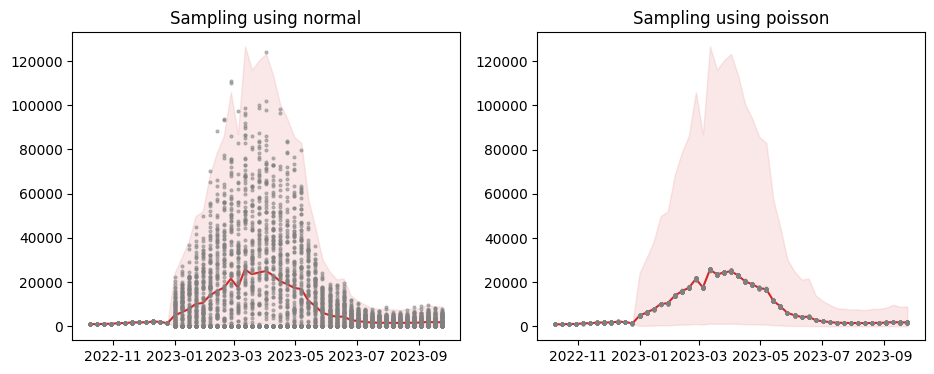

In [8]:
state = 'PR'
model_id = 28
year = 2023

dates = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end = Week(2023, 39).startdate().strftime('%Y-%m-%d'), freq = 'W-SUN')

df_pred = pd.read_csv(f'./predictions/preds_{model_id}_{state}_{year}.csv.gz')

df_pred.date = pd.to_datetime(df_pred.date)

df_pred = df_pred.loc[df_pred.date.isin(dates)]

fig, ax = plt.subplots(1,2, figsize = (11, 4))

ax[0].set_title('Sampling using normal')

ax[0].plot(df_pred.date, df_pred.pred,color = 'tab:red')

ax[0].fill_between(df_pred.date, df_pred.lower, df_pred.upper, color= 'tab:red', alpha=0.1)

X, y = get_samples(state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))

for i in np.arange(0,100):
    
    ax[0].plot(df_pred.date, SprintModel(model_id = model_id, state = state, mean =False).predict(X.values), 
           color = 'gray', linestyle = '', marker = 'o',  markersize =2, alpha = 0.5)

ax[1].set_title('Sampling using poisson')

ax[1].plot(df_pred.date, df_pred.pred,color = 'tab:red')

ax[1].fill_between(df_pred.date, df_pred.lower, df_pred.upper, color= 'tab:red', alpha=0.1)

for i in np.arange(0,100):
    
    ax[1].plot(df_pred.date, SprintModel(model_id = model_id, state = state, mean =False, dist = 'poisson').predict(X.values), 
           color = 'gray', linestyle = '', marker = 'o',  markersize =2, alpha = 0.5)
    
plt.show()

### Applying the stacking using the `pred` column only (mean = True)

In the cell below, the stacking regressor will be applied using LASSO as the final estimator. The stack model is trained using the predictions for 2023 and tested using the predictions for 2024. The performance of the train and test are shown in the figure. 

The worst performance in 2024 is expected since the models that performed better in 2023 performed worse in 2024. 

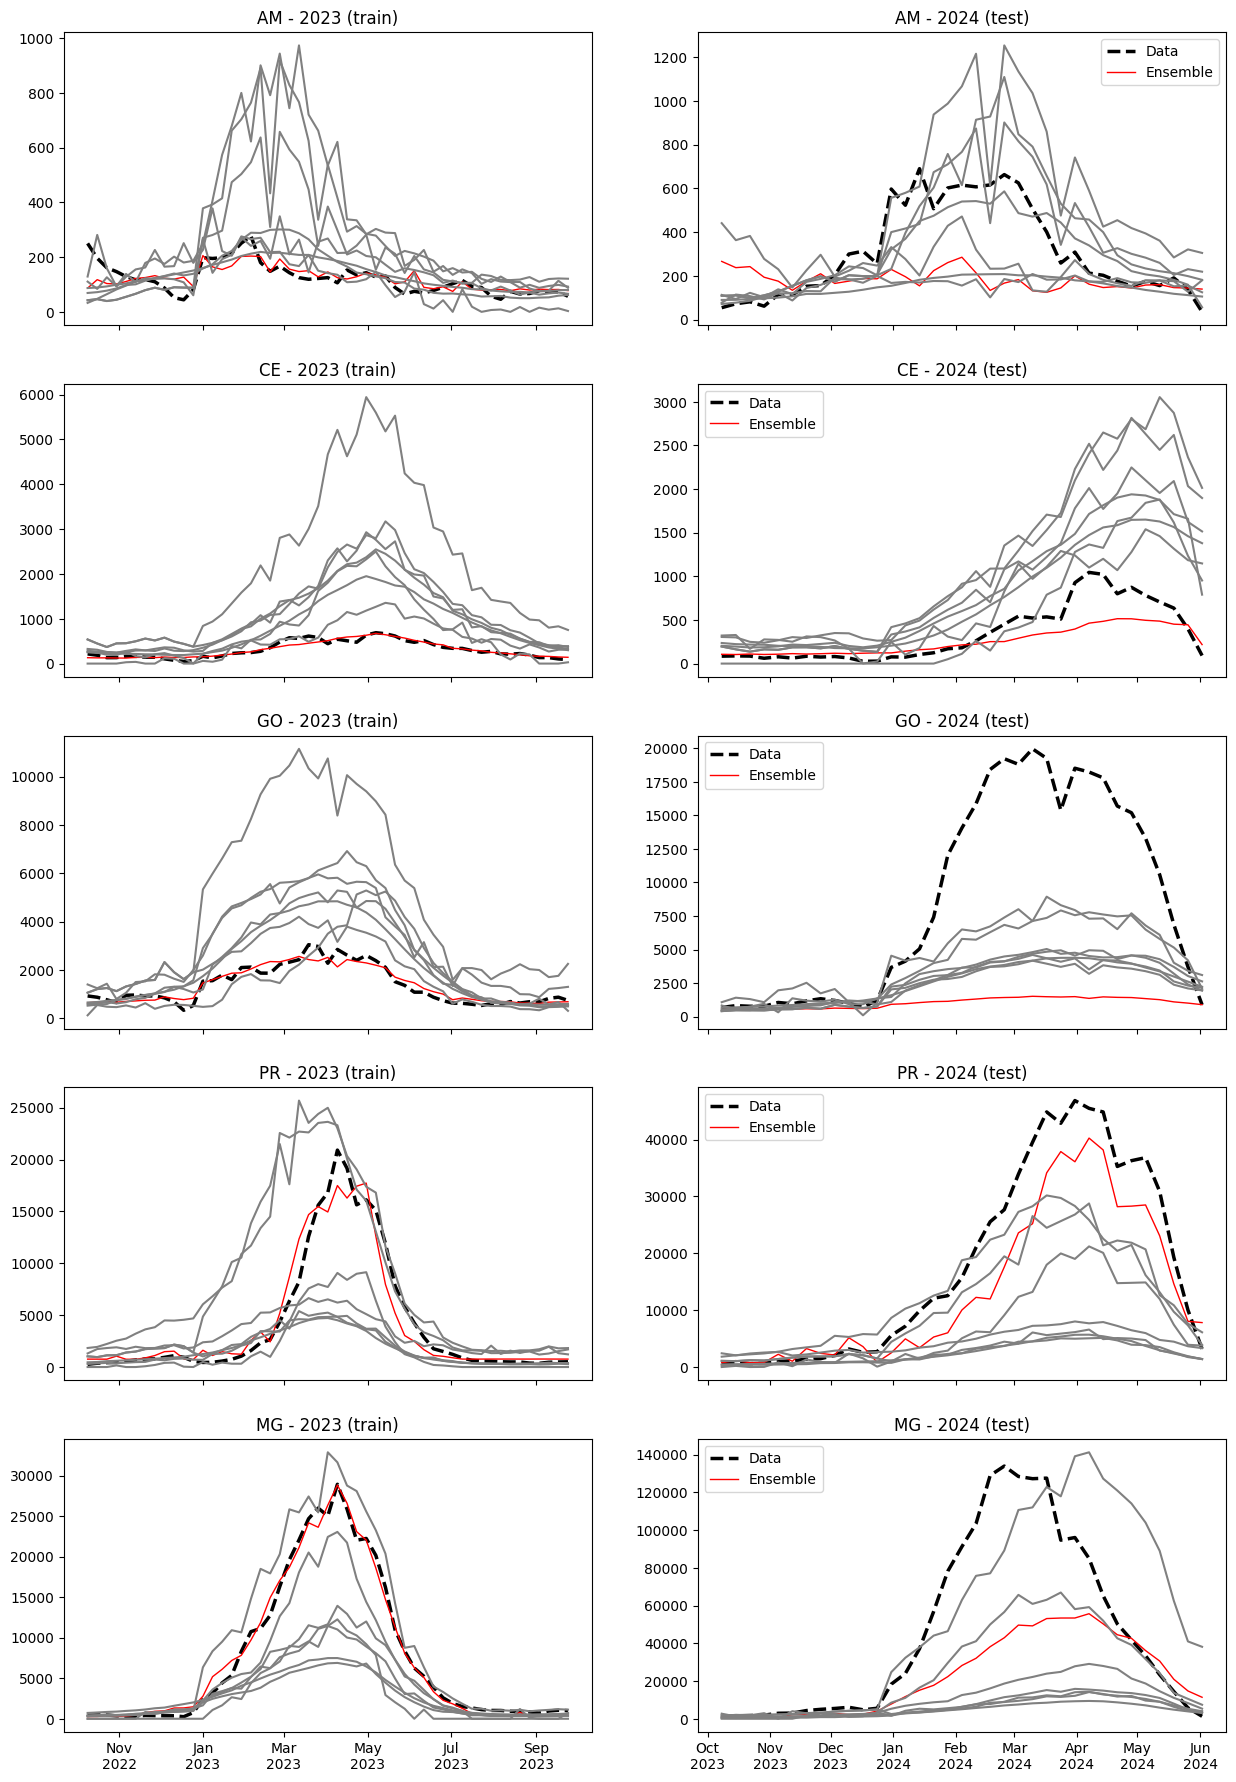

In [9]:
fig, axs  = plt.subplots(5,2, figsize = (15, 25))

ax = axs.ravel()

list_coef = []
i = 0
for state in ['AM', 'CE', 'GO', 'PR', 'MG']: 

    X, y = get_samples(state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))
    
    
    estimators = []
    
    for model_id in [21,22,25,27,28,29,30]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state)))
    
        
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=LassoCV()
    )
    
    stack.fit(X.values, y)
    
    stack_preds = stack.predict(X.values)

    dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    ax[i].plot(dates_23, y, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
    
    ax[i].plot(dates_23, stack_preds, color = 'red', label = 'Ensemble', linewidth = 1)
    
    for model_id in [21,22,25,27,28,29,30]:
    
        ax[i].plot(dates_23, SprintModel(model_id = model_id, state = state).predict(X.values),
               color = 'grey')

    ax[i].set_title(f'{state} - 2023 (train)')

    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
            


    X, y = get_samples(state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                          end_date = '2024-06-02')

    stack_preds = stack.predict(X.values)
    
    dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                  end= '2024-06-02',
                  freq='W-SUN')

    ax[i+1].plot(dates_24, y, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)

    ax[i+1].plot(dates_24, stack_preds, color = 'red', label = 'Ensemble', linewidth = 1)
    
    for model_id in [21,22,25,27,28,29,30]:
        
        ax[i+1].plot(dates_24, SprintModel(model_id = model_id, state = state).predict(X.values),
               color = 'grey')
    
    ax[i+1].legend()
    
    ax[i+1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
            
    ax[i+1].set_title(f'{state} - 2024 (test)')

    df_coef = pd.DataFrame()

    df_coef['model_id'] = [name for name, _ in estimators]
    df_coef['coef'] = stack.final_estimator_.coef_
    df_coef['state'] = state

    list_coef.append(df_coef)
    
    i = i+2

# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')

plt.savefig('ensemble.png', dpi = 600, bbox_inches = 'tight')

plt.show()


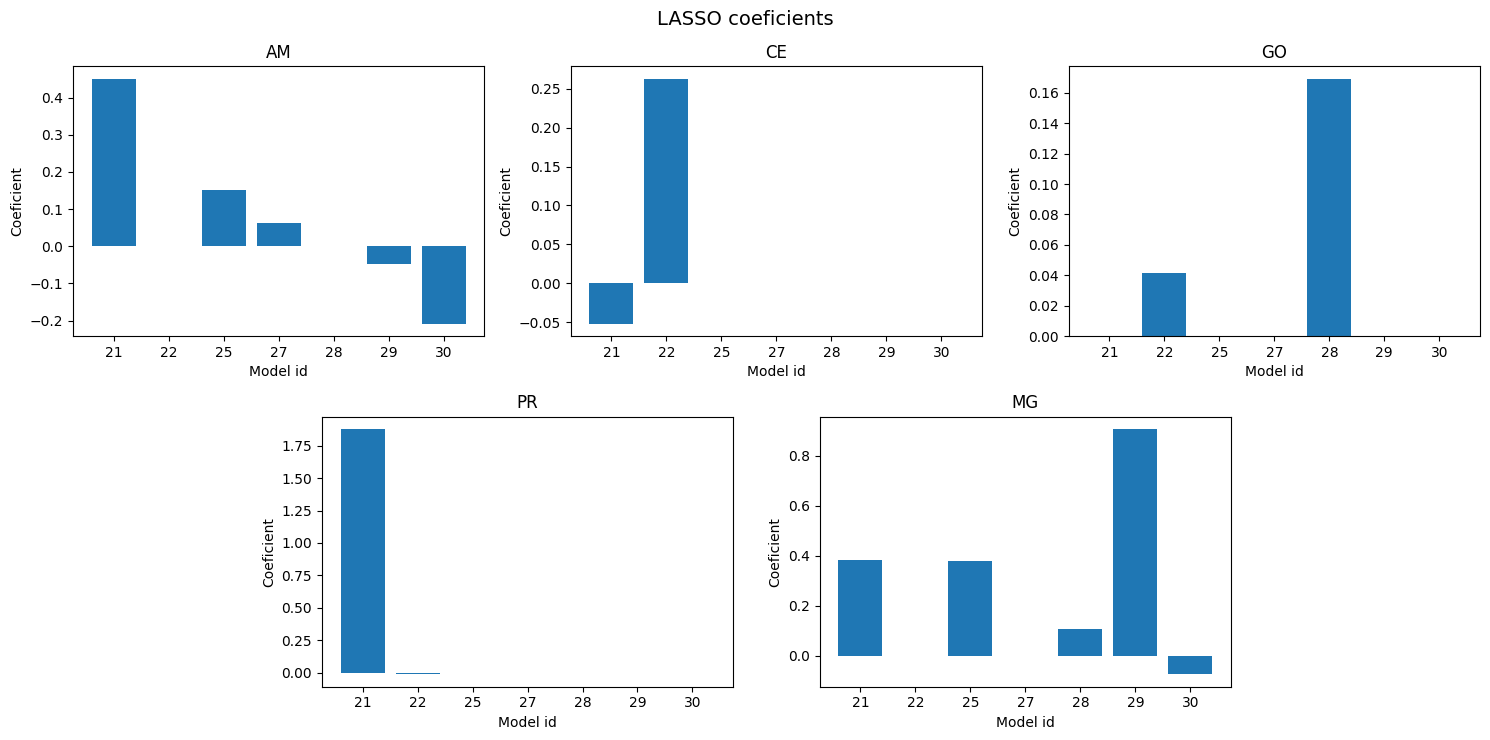

In [10]:
df_coef = pd.concat(list_coef).reset_index(drop = True)

plot_coef(df_coef)

In the cell below, the stacking regressor will be applied using LASSO as the final estimator. The stack model is trained using the predictions from 2023 and 2024. The Figure represents the in sample performance in each state. 

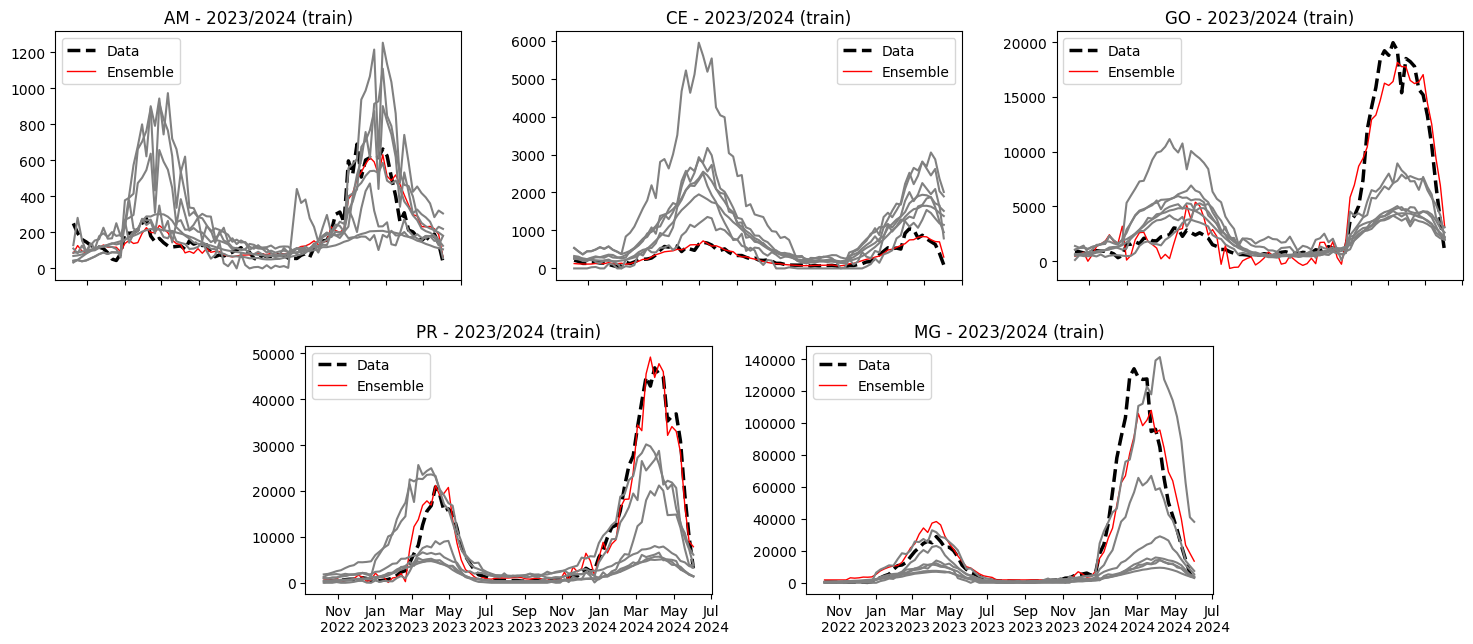

In [11]:
fig = plt.figure(figsize=(15, 7.5))
gs = gridspec.GridSpec(2, 6, figure=fig)
    
# First row with three boxplots
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
    
# Second row with two boxplots
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

list_coef = []
i = 0
for state, ax  in zip(['AM', 'CE', 'GO', 'PR', 'MG'],
                      [ax1,ax2,ax3,ax4,ax5]): 

    X1, y1 = get_samples(state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))
    X2, y2 = get_samples(state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2024, 23).startdate().strftime('%Y-%m-%d'))

    X = pd.concat([X1, X2])
    y = np.append(y1,y2, axis =0)
    
    estimators = []
    
    for model_id in [21,22,25,27,28,29,30]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state)))
        
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=LassoCV()
    )
    
    stack.fit(X.values, y)
    
    stack_preds = stack.predict(X.values)

    dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 23).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    dates = np.append(dates_23,dates_24, axis =0)

    ax.plot(dates, y, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
    
    ax.plot(dates, stack_preds, color = 'red', label = 'Ensemble', linewidth = 1)
    
    for model_id in [21,22,25,27,28,29,30]:
    
        ax.plot(dates, SprintModel(model_id = model_id, state = state).predict(X.values),
               color = 'grey')

    ax.set_title(f'{state} - 2023/2024 (train)')
 
    ax.legend()    

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'

    df_coef = pd.DataFrame()

    df_coef['model_id'] = [name for name, _ in estimators]
    df_coef['coef'] = stack.final_estimator_.coef_
    df_coef['state'] = state

    list_coef.append(df_coef)
            
    i = i +1

plt.tight_layout()
# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')

plt.show()


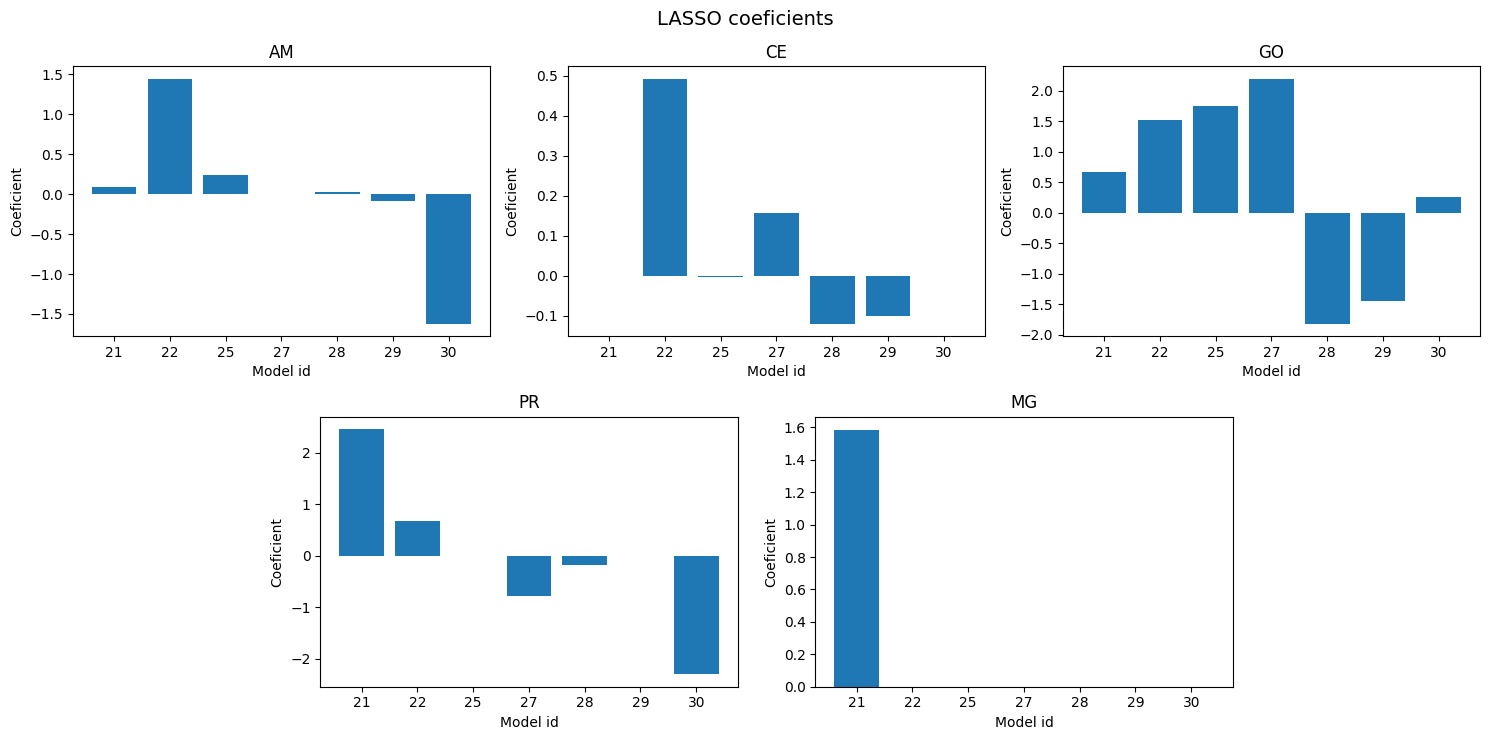

In [12]:
df_coef = pd.concat(list_coef).reset_index(drop = True)

plot_coef(df_coef)

### Training and evaluating using sampled observations from the preds: 

In the cell below, the stacking regressor will be applied using LASSO as the final estimator. The stack model is trained using the predictions for 2023 and tested using the predictions for 2024. The performance of the train and test are shown in the figure. The training and testing is done using 100 observations sampled from the models.

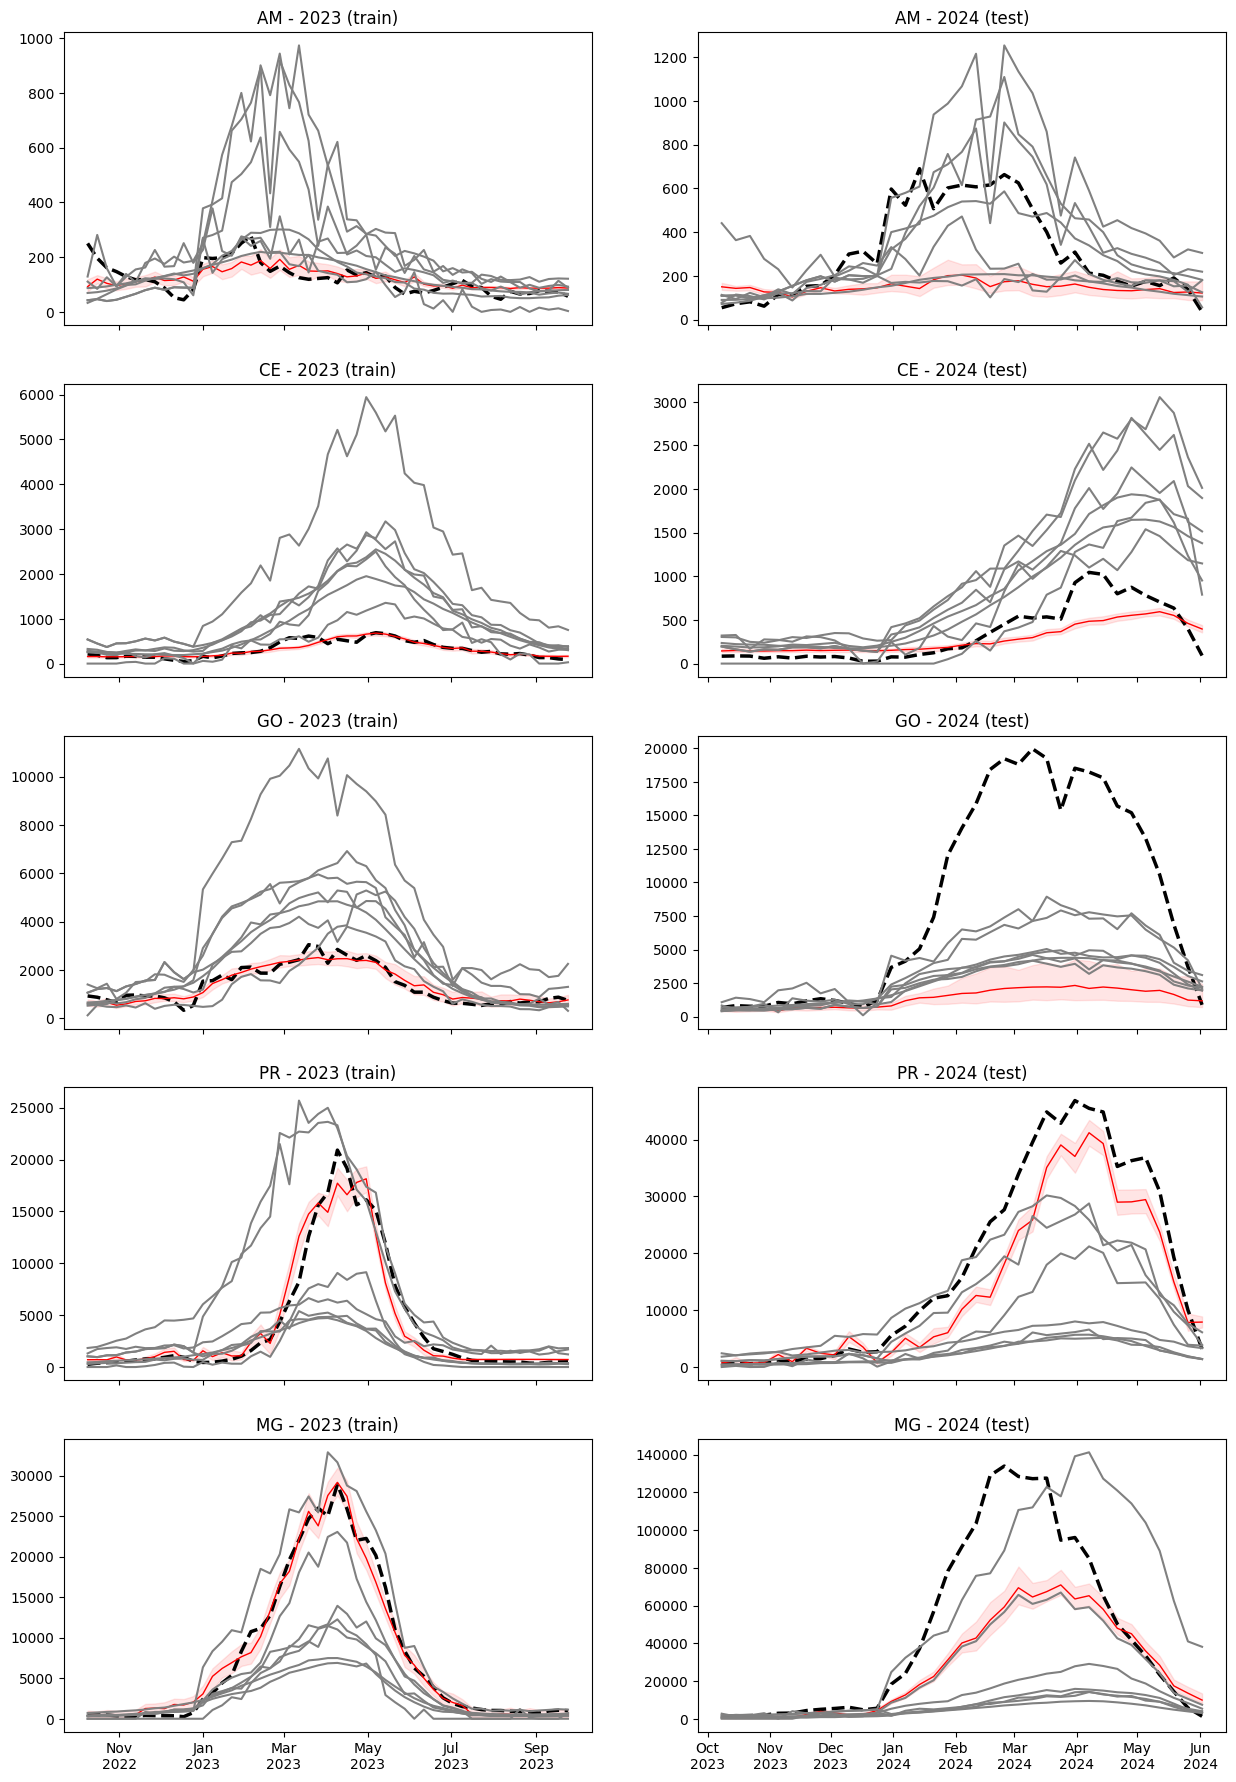

CPU times: user 1min 39s, sys: 1.16 s, total: 1min 40s
Wall time: 1min 39s


In [13]:
%%time
fig, axs  = plt.subplots(5,2, figsize = (15, 25))

ax = axs.ravel()

j = 0
list_coef = []
for state in ['AM', 'CE', 'GO', 'PR', 'MG']: 

    list_X = []# pd.concat([X1, X2])
    y = np.array([])
    for i in np.arange(0,100): 
        
        X_, y_ = get_samples(state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                                  end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))

        list_X.append(X_)

        y = np.append(y,y_, axis =0)
        
    X = pd.concat(list_X)
        
    estimators = []
    
    for model_id in [21,22,25,27,28,29,30]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state, mean = False)))
           
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=LassoCV()
    )
    
    stack.fit(X.values, y)

    stack_preds = np.empty((0, 51))
    
    for i in np.arange(0,100):
        stack_preds_ = stack.predict(X_.values).reshape(1,-1)

        stack_preds = np.append(stack_preds, stack_preds_, axis=0)

    lower = np.percentile(stack_preds, 5, axis =0)
    pred = np.percentile(stack_preds, 50, axis =0)
    upper = np.percentile(stack_preds, 95, axis =0)

    dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    ax[j].plot(dates_23, y_, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
    
    ax[j].plot(dates_23, pred, color = 'red', label = 'Ensemble', linewidth = 1)

    ax[j].fill_between(dates_23, lower, upper, color = 'red', alpha=0.1)
    
    for model_id in [21,22,25,27,28,29,30]:
    
        ax[j].plot(dates_23, SprintModel(model_id = model_id, state = state, mean = True).predict(X_.values),
               color = 'grey')

    ax[j].set_title(f'{state} - 2023 (train)')

    
    ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y')) 

    list_X = []
    y = np.array([])
    for i in np.arange(0,100): 
        
        X_, y_ = get_samples(state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                                  end_date = Week(2024, 23).startdate().strftime('%Y-%m-%d'))

        list_X.append(X_)

        y = np.append(y,y_, axis =0)
        
    X = pd.concat(list_X)
           
    stack_preds = np.empty((0, 35))
    
    for i in np.arange(0,100):
        stack_preds_ = stack.predict(X_.values).reshape(1,-1)

        stack_preds = np.append(stack_preds, stack_preds_, axis=0)

    lower = np.percentile(stack_preds, 5, axis =0)
    pred = np.percentile(stack_preds, 50, axis =0)
    upper = np.percentile(stack_preds, 95, axis =0)

    dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 23).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    ax[j+1].plot(dates_24, y_, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
    
    ax[j+1].plot(dates_24, pred, color = 'red', label = 'Ensemble', linewidth = 1)

    ax[j+1].fill_between(dates_24, lower, upper, color = 'red', alpha=0.1)
    
    for model_id in [21,22,25,27,28,29,30]:
    
        ax[j+1].plot(dates_24, SprintModel(model_id = model_id, state = state, mean = True).predict(X_.values),
               color = 'grey')

    ax[j+1].set_title(f'{state} - 2024 (test)')

    
    ax[j+1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22

    df_coef = pd.DataFrame()

    df_coef['model_id'] = [name for name, _ in estimators]
    df_coef['coef'] = stack.final_estimator_.coef_
    df_coef['state'] = state

    list_coef.append(df_coef)
    
    j = j+2

# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')

plt.savefig('ensemble_ci.png', dpi = 600, bbox_inches = 'tight')

plt.show()

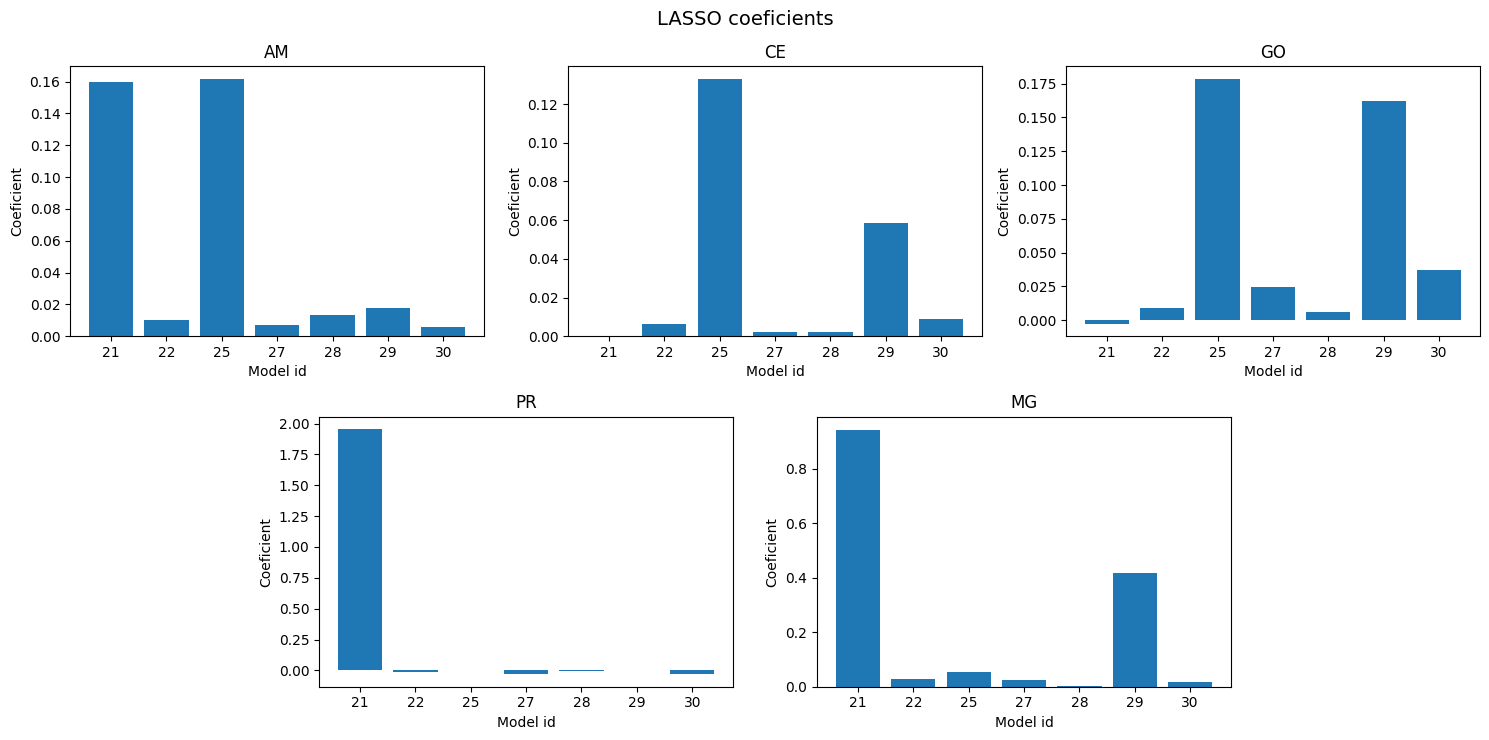

In [14]:
df_coef = pd.concat(list_coef).reset_index(drop = True)

plot_coef(df_coef)

In [15]:
stack

StackingRegressor(estimators=[('21',
                               SprintModel(mean=False, model_id=21,
                                           state='MG')),
                              ('22',
                               SprintModel(mean=False, model_id=22,
                                           state='MG')),
                              ('25',
                               SprintModel(mean=False, model_id=25,
                                           state='MG')),
                              ('27',
                               SprintModel(mean=False, model_id=27,
                                           state='MG')),
                              ('28',
                               SprintModel(mean=False, model_id=28,
                                           state='MG')),
                              ('29',
                               SprintModel(mean=False, model_id=29,
                                           state='MG')),
                              ('30',
                               SprintModel(mean=False, model_id=30,
                                           state='MG'))],
                  final_estimator=LassoCV())

In the cell below, the stacking regressor will be applied using LASSO as the final estimator. The stack model is trained using the predictions for 2023 and 2024. The performance of the train data is shown in the figure. The training and prediction are done using 100 observations sampled from the models.

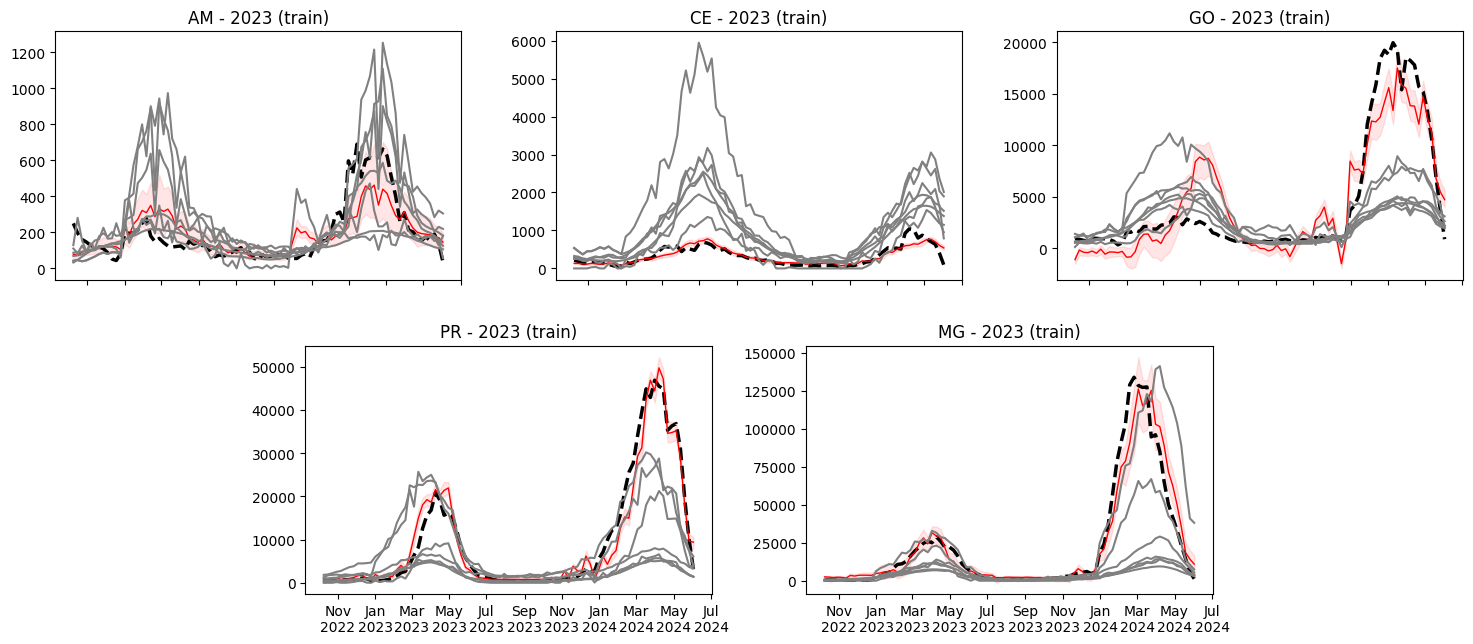

In [16]:
fig = plt.figure(figsize=(15, 7.5))
gs = gridspec.GridSpec(2, 6, figure=fig)
    
# First row with three boxplots
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
    
# Second row with two boxplots
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

list_coef = []
i = 0
for state, ax  in zip(['AM', 'CE', 'GO', 'PR', 'MG'],
                      [ax1,ax2,ax3,ax4,ax5]): 

    list_X = []# pd.concat([X1, X2])
    y = np.array([])
    for i in np.arange(0,100):

        X1, y1 = get_samples(state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))
        
        X2, y2 = get_samples(state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                                  end_date = Week(2024, 23).startdate().strftime('%Y-%m-%d'))
    
        X_ = pd.concat([X1, X2])
        y_ = np.append(y1,y2, axis =0)
            
        list_X.append(X_)
        
        y = np.append(y,y_, axis =0)
        
    X = pd.concat(list_X)
        
    estimators = []
    
    for model_id in [21,22,25,27,28,29,30]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state, mean = False)))
           
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=LassoCV()
    )
    
    stack.fit(X.values, y)

    stack_preds = np.empty((0, 86))
    
    for i in np.arange(0,100):
        stack_preds_ = stack.predict(X_.values).reshape(1,-1)

        stack_preds = np.append(stack_preds, stack_preds_, axis=0)

    lower = np.percentile(stack_preds, 5, axis =0)
    pred = np.percentile(stack_preds, 50, axis =0)
    upper = np.percentile(stack_preds, 95, axis =0)

    dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 23).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    dates = np.append(dates_23,dates_24, axis =0)
    
    ax.plot(dates, y_, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
    
    ax.plot(dates, pred, color = 'red', label = 'Ensemble', linewidth = 1)

    ax.fill_between(dates, lower, upper, color = 'red', alpha=0.1)
    
    for model_id in [21,22,25,27,28,29,30]:
    
        ax.plot(dates, SprintModel(model_id = model_id, state = state, mean = True).predict(X_.values),
               color = 'grey')

    ax.set_title(f'{state} - 2023 (train)')

    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y')) 
        
    df_coef = pd.DataFrame()

    df_coef['model_id'] = [name for name, _ in estimators]
    df_coef['coef'] = stack.final_estimator_.coef_
    df_coef['state'] = state

    list_coef.append(df_coef)

plt.tight_layout()
# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')

plt.show()

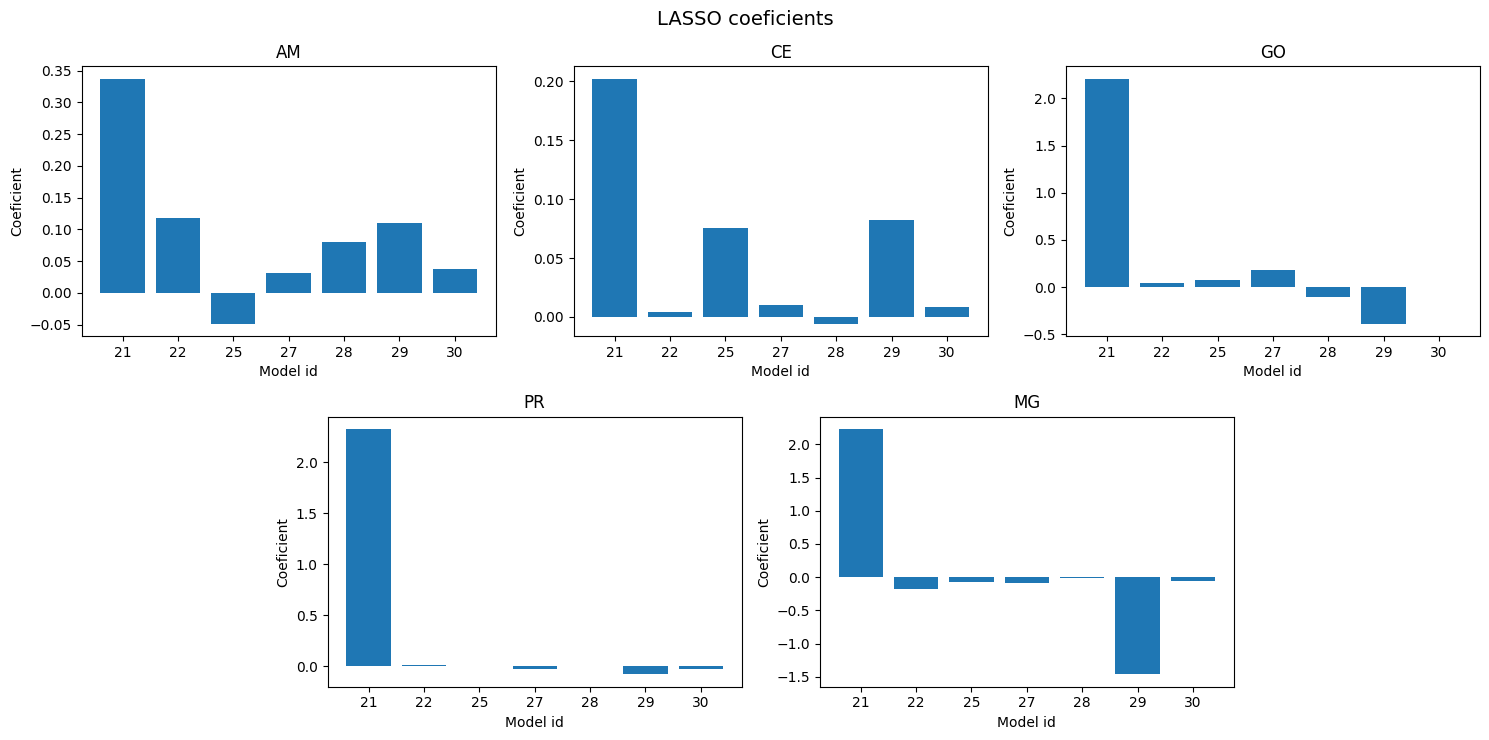

In [17]:
df_coef = pd.concat(list_coef).reset_index(drop = True)

plot_coef(df_coef)